In [1]:
#Importing packages
from selenium import webdriver
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from itertools import chain
nltk.download('punkt')
nltk.download('wordnet')

import matplotlib.pyplot as plt
%matplotlib inline  

pd.set_option('display.max_rows', 500)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load the data

In [11]:
df = pd.read_csv("text_project_news_sub.csv", parse_dates=['date'])
# df = df[['Date', 'user_id', 'comments']]
df = df.dropna()

In [12]:
df.shape

(13596, 5)

In [13]:
df.head()

,Unnamed: 0,source,fulltext,date,polarity
0,0,reuters,3 Min ReadTOKYO (Reuters) - The dollar rose to...,2019-08-01,0.048919
1,1,guardian,The head of the Chinese army in Hong Kong has ...,2019-08-01,0.028030
2,2,reuters,7 Min ReadTo access a PDF version of this news...,2019-08-01,0.043743
3,3,reuters,3 Min ReadAug 1 (Reuters) - The following are ...,2019-08-01,0.062451
4,4,guardian,"Osama bin Laden’s son, Hamza, is believed to b...",2019-08-01,-0.047654


### Preprocess comments

In [14]:
%%time
# tokenization
df['tokens'] = df['fulltext'].map(nltk.word_tokenize)
# df['bigrams'] = df['tokens'].map(lambda x: list(nltk.bigrams(x)))
# df['trigrams'] = df['tokens'].map(lambda x: list(nltk.trigrams(x)))
df['tokens'] = df['tokens'].map(lambda x: set(x))


Wall time: 39.1 s


In [15]:
%%time

# lemmatization
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df ['tokens'].map(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['lemmatized'] = df['lemmatized'].map(lambda x: set(x))

# remove stop words
stop_words = set(stopwords.words('english'))
df['processed'] = df['lemmatized'].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove punctuations
punc = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df['processed'] = df['processed'].map(lambda x: [word for word in x if word.lower() not in punc])

# remove some other stuff and return lower case
others = ["''", "``", "n't", "l", "oh", "lol", "'m", "'s"]
df['processed'] = df['processed'].map(lambda x: [word.lower() for word in x if word.lower() not in others])

Wall time: 16.5 s


In [20]:
np.sum(df['processed'].map(lambda x: 'sanders' in x))

72

In [6]:
%%time
models = pd.read_csv("models (5).csv", header = None)
models.columns = ['brand', 'model']

## clean brand list
models.loc[(models['brand'] == 'mercedes'),'brand'] = 'mercedes-benz'
models.loc[(models['brand'] == 'mercedes benz'),'brand'] = 'mercedes-benz'
models.loc[(models['brand'] == 'kia.'),'brand'] = 'kia'
models.loc[(models['brand'] == 'kia,'),'brand'] = 'kia'
models.loc[(models['brand'] == 'hyndai kia'),'brand'] = 'kia'
models.loc[(models['brand'] == 'hyundai,'),'brand'] = 'hyundai'
models.loc[(models['brand'] == 'hyundai.'),'brand'] = 'hyundai'
models.loc[(models['brand'] == 'nissan.'),'brand'] = 'nissan'
models.loc[(models['brand'] == 'toyata'),'brand'] = 'toyota'
models.loc[(models['brand'] == 'volkwagen'),'brand'] = 'volkswagen'

def model_to_brand(word):
    if word.lower() in models['model'].values:
        brand = models[models['model'] == word].iloc[-1,0]
#         print('replace ' + word + ' to ' + brand)
        return(brand)
    else:
        return(word)

df['processed'] = df['processed'].map(lambda x: [model_to_brand(word) for word in x])

Wall time: 24.8 s


# Task A
**Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task). For lift calculations, be sure not to count a mention more than once per post, even if it is mentioned multiple times in the post.
Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on the Internet).**

### Top 10 brands 

In [7]:
all_words = pd.Series(chain(*list(df['processed'])))
word_frequency = all_words.value_counts()

brand_list = models['brand'].drop_duplicates().values
no_use = ['car', 'sedan', 'seat', 'problem']
brand_list = [ x for x in brand_list if x not in no_use]

tmp = pd.DataFrame(word_frequency)
tmp['word'] = word_frequency.index
mask = tmp['word'].isin(brand_list)
brand_frequency = word_frequency[mask]
top10_brands = brand_frequency.head(10)
top10_brands

bmw              2551
audi             1911
acura            1134
honda            1000
infiniti          662
volkswagen        539
toyota            488
mercedes-benz     411
hyundai           396
ford              376
dtype: int64

### Lift Calculations  

In [8]:
def lift(a, b):
    N = df['processed'].shape[0]
    N_ab = sum(df['processed'].map(lambda x: a in x and b in x))
    N_a = sum(df['processed'].map(lambda x: a in x))
    N_b = sum(df['processed'].map(lambda x: b in x))
    if N_a*N_b == 0:
        return(None)
    else:
        return(N*N_ab/(N_a*N_b))

lift_brands = pd.DataFrame(top10_brands.index.values, columns=['brand'])
for make in top10_brands.index.values:
    lift_brands[make] = lift_brands['brand'].map(lambda x: lift(x, make))
lift_brands = lift_brands.set_index('brand')
lift_brands

,bmw,audi,acura,honda,infiniti,volkswagen,toyota,mercedes-benz,hyundai,ford
brand,,,,,,,,,,
bmw,3.889119,1.786978,1.325522,1.098865,1.894895,1.179733,1.380993,2.622126,1.247200,1.406985
audi,1.786978,6.082658,2.173920,1.583850,2.593196,2.580048,1.508753,3.480728,1.803823,1.224836
acura,1.325522,2.173920,8.882840,3.260322,3.298343,1.392939,1.553917,2.617041,1.531524,1.121724
honda,1.098865,1.583850,3.260322,10.396122,1.409297,2.138020,3.202983,1.737595,1.828284,2.022454
infiniti,1.894895,2.593196,3.298343,1.409297,14.746562,1.250994,1.617116,3.467322,2.034009,1.258239
volkswagen,1.179733,2.580048,1.392939,2.138020,1.250994,19.295630,2.367871,1.639855,2.195710,2.831782
toyota,1.380993,1.508753,1.553917,3.202983,1.617116,2.367871,19.597911,1.998654,3.041055,2.742370
mercedes-benz,2.622126,3.480728,2.617041,1.737595,3.467322,1.639855,1.998654,21.263456,2.126346,2.177146
hyundai,1.247200,1.803823,1.531524,1.828284,2.034009,2.195710,3.041055,2.126346,25.882759,2.031752


### MDS map

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


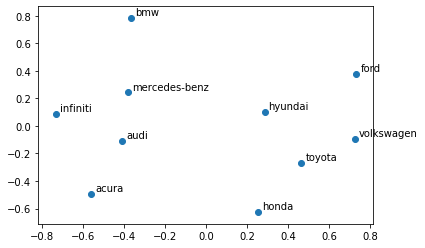

In [9]:
from sklearn.manifold import MDS
inverse_lift_brands = lift_brands.apply(lambda x: 1/x)
embedding = MDS(n_components=2, random_state=4)
mds = embedding.fit_transform(inverse_lift_brands)
mds_output = pd.DataFrame(mds, index=inverse_lift_brands.index.values, columns=['x', 'y'])

fig, ax = plt.subplots()
ax.scatter(mds_output['x'], mds_output['y'])
for brand in inverse_lift_brands.index.values:
    ax.text(mds_output.loc[brand, 'x']+0.02, mds_output.loc[brand, 'y']+0.02, brand)

# Task B
**What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)?**

#### (1) Volkswagen: a suspicious luxury brand
Noticing that Volkswagen has a strong accociation with Audi looking at lift, we firstly hypothesized that volkswagen may have been percieved as a luxury brand in recent years. However, with further examined, we found that Volkswagen is not strongly associated with the other mentioned luxury brands and is much more associated with the non-luxury Japanese and American brands. This can be seen through the MDS plot, Volkswagen is much more associated with Ford, Toyota, Honda, and Hyundai than the luxury brands. Through researching these two brands, Audi cars are manufactured under the Volkswagen group, that is most likely why they are associated since many of the low end Audis have the same basic parts and consumers are comparing them. 

#### (2) Mercedes-bendz: the middle man 
Mercedes-bends, looking at the MDS plot is definintely apart of the luxury brand cluster. Mercedes-bends also has high lift values with the other luxury brands, but it also has pretty high lift values with non-luxury brands hyundai (2.126346) and Ford (2.177146). This might have been caused by the non-luxury brands users wanting to upgrade to a luxury brand car and Mercedes-bendz is the brand they are considering the most. 

# Task C
**What are 5 most frequently mentioned attributes of cars in the discussions? Note that the same attribute may be described by different words – e.g., pick-up and acceleration may both refer to a more general attribute, “performance”. You have to make suitable replacements. Now pick the 5 most frequently mentioned brands. Which attributes are most strongly associated with which of these 5 brands? You DON’T have to do a sentiment analysis for this assignment.
Here we need to re-do the attribute_dict. I will produce a big table of brands and attributes.**

#### Attributes extraction:

1. We went through 300 most frequently mentioned words and grouped them into attributes based on our interpretation of the meaning of the words.
2. Then we filtered words that either not has lift than 1 with other words. For example, lift('mpg', 'oil') was 0.8, so we removed 'oil' from fuel efficiency.
3. Next, we removed words that have a different level of lift with a specific brand. For example, lift('speed', 'bmw') was 0.9, and lift('performance', 'bmw') was 2.3, the word 'speed' might not be a good proxy of performance, so we removed the word 'speed'. 

In [20]:
# Initial attribute_dict

attribute_dict = { 
    'performance': ['drive', 'engine', 'driving', 'performance', 'power', 'speed'],
    
    'fuel_efficiency': ['mile', 'oil' , 'mpg', 'gas'],
    
    'look': ['look', 'pretty', 'looking', 'wheel', 'tire', 'sport'],
    
    'luxury': ['luxury', 'premium'],
    
    'reliability': ['issue', 'problem'],
            
    'size': ['size', 'sedan', 'big', 'little', 'small', 'size']}

In [19]:
# this block is for step 2 and 3 of attributes extraction
# we comment out the print of dataframe to keep the notebook clean

n_b = 5 # top n brands we want to look at

for attribute in attribute_dict:
    tolook = list(top10_brands[:n_b].index.values)
    tolook = tolook + attribute_dict[attribute]

    lift_df = pd.DataFrame(tolook, columns=['to_check'])
    for make in tolook:
        lift_df[make] = lift_df['to_check'].map(lambda x: lift(x, make))
    lift_df = lift_df.set_index('to_check')
#     display(lift_df)

In [21]:
# this is the final attribute_dict

attribute_dict = { 
    'performance': ['drive', 'engine', 'driving', 'performance', 'power'],
    
    'fuel_efficiency': ['mile', 'mpg', 'gas'],
    
    'look': ['look', 'pretty', 'looking', 'wheel', 'tire', 'sport'],
    
    'luxury': ['luxury', 'premium'],
    
    'issue_problem': ['issue', 'problem'],
            
    'size': ['size', 'small']}

### Top 5 attributes

In [22]:
def count_attribute(df, attribute_terms):
    return(np.sum(df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1 )))

top_attributes = pd.DataFrame(pd.Series(attribute_dict), columns=['attribute_terms'])
top_attributes['count'] = top_attributes['attribute_terms'].map(lambda x: count_attribute(df, x))

top_attributes = top_attributes.sort_values(by=['count'], ascending=False)
top_attributes[:5]

,attribute_terms,count
performance,"[drive, engine, driving, performance, power]",2253
look,"[look, pretty, looking, wheel, tire, sport]",2252
fuel_efficiency,"[mile, mpg, gas]",987
issue_problem,"[issue, problem]",793
luxury,"[luxury, premium]",684


### Top 5 attributes and top 5 brands

In [14]:
def lift_attribute_to_brands(attribute, attribute_dict, brand_list, df, bigram=False):
    '''
    attribute is a string
    
    attribute_dict is the dictionary whose keys are attibutes and values are words(attribute_terms).
    
    df is the processed dataframe contains processed comments 
    '''
    attribute_terms = attribute_dict[attribute]
    output = dict()
    for brand in brand_list.index.values:
        if bigram == True:
            mask = df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1) | \
                df['bigrams'].map(lambda x: len([term for term in attribute_terms if term in x])>=1) | \
                df['trigrams'].map(lambda x: len([term for term in attribute_terms if term in x])>=1)
            df_a = df[mask]
        else:
            df_a = df[df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1)]
        N_a = df_a.shape[0] # count of comments w/ attribute
        N_b = sum(df['processed'].map(lambda x: brand in x)) # count of comments w/ brand
        N = df['processed'].shape[0]
        N_ab = sum(df_a['processed'].map(lambda x: brand in x)) # count of cooments w/ attribute and brand
        
        try:
            output[brand] = N*N_ab/(N_a*N_b)
        except:
            output[brand] = None
#         print(brand, N_a, N_b, N, N_ab)    
    return(output)

In [15]:
brand_list = top10_brands[:5]
output = pd.DataFrame(top_attributes.index.values[:5], columns=['attribute'])

for attribute in top_attributes.index.values[:5]:
    tmp = lift_attribute_to_brands(attribute, attribute_dict, brand_list, df)
    tmp = pd.Series(tmp).sort_values(ascending=False)
    output[attribute] = list(zip(tmp.index.values, np.round((tmp.values), 4)))

output = output[top_attributes.index.values[:5]]
output

,performance,look,fuel_efficiency,issue_problem,luxury
0,"(audi, 1.6037)","(audi, 1.5801)","(honda, 1.6853)","(audi, 1.8179)","(audi, 2.3388)"
1,"(infiniti, 1.5512)","(infiniti, 1.4864)","(audi, 1.4667)","(bmw, 1.5056)","(infiniti, 2.3068)"
2,"(bmw, 1.4966)","(acura, 1.4752)","(acura, 1.44)","(infiniti, 1.4877)","(honda, 2.1735)"
3,"(honda, 1.4489)","(honda, 1.468)","(bmw, 1.1979)","(honda, 1.4814)","(acura, 2.1688)"
4,"(acura, 1.4115)","(bmw, 1.4403)","(infiniti, 1.1953)","(acura, 1.4338)","(bmw, 1.7399)"


## Task D
**What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it is positive).**

#### (1) Audi: a luxury brand with great performance, stylish look, and -- a lot of issues?
Audi seems to be doing great in almost all the attributes ranging from luxury to fuel efficiency. But, it is at the top of the “issue problem” attribute. They have to take this negative aspect seriously as the majority of the customers would have paid a good amount to get an Audi.

They can offer programs that can help in easing the process of fixing any issues faced by the buyer. Like, offer services to towing the vehicle from the customer home and offering them a replacement meanwhile the car gets repaired. 

If they can manage to make the repair process easier and more personalized for the customer, they can be at the top of all the major attributes. This will further strengthen their foothold in the luxury market.


#### (2) BMW: something's wrong with their entry-level models!
Though BMW claims the title of “The Ultimate Driving Machine”, the lift calculations show that Audi and Infiniti are still leading in “performance”.  If the tagline must genuinely reflect what BMW offers, the performance factor must be improved. This is both the product and the marketing managers’ problems. The product manager needs to find out why consumers do not highly rate BMW’s performance and using this knowledge, change the models to reflect better performance. Then the marketing managers need to advertise/communicate this change to consumers. 

Upon considering other attributes, BMW does not score well either. For example, BMW scores low on the “look” attribute. BMW, being the luxury brand it is, needs to have a look at their designs as well, as luxury brands are sought out based on their designs along with the performance. 


## Task E
**Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?**

Infiniti is the most aspirational brand in our data. We used unigrams, bigrams, and trigrams that could be synonyms for aspiration in our scoring. This is an opportunity for Infiniti since many people want to buy their cars and looking at the lift values, Infiniti is mainly being compared with other luxury brands. If Infiniti can differentiate itself from the other luxury brands especially Mercedes-Benz, since Mercedes-Benz has the second-highest aspiration score. By advertise this difference, Infiniti could increase its market share, especially in non-US markets. This is because Infiniti has low market share in non-US markets. 

In [16]:
aspiration_dict = { 'aspiration': [("dream", "of"), ("love", "to"), ("the", "best"), ("would", "love"), 
                                   ("must", "have"), ("must", "get"), ("first", "chance"), 
                                  ('dream', 'car'), 'dreamed', 'dreaming', ('dream', 'of'), 
                                   ('dream', 'to'), ("couldn't", 'afford'),
                                   'wish','best', ('wanted', 'to'), ('future', 'car'),
                                  ( 'love', 'to', 'have'), ('would', 'like', 'to'), ('want', 'to', 'get'), 
                                   ('want', 'to', 'have'), ('wish', 'to', 'buy')] }

In [17]:
brand_list = top10_brands

output = lift_attribute_to_brands('aspiration', aspiration_dict, brand_list, df, bigram=True)
output = pd.Series(output).sort_values(ascending=False)
print(output)

infiniti         2.115719
mercedes-benz    1.891441
toyota           1.771404
audi             1.727929
hyundai          1.671053
honda            1.670539
acura            1.656771
bmw              1.411689
ford             1.286401
volkswagen       1.273456
dtype: float64
